# L15 - 3D Gaussian Splatting

### Outline for today:

- Tidy up from last time: Structure from Motion
  - Two-view modeling
  - Triangulation (add points)
  - Resectioning (add cameras)
  - Bundle adjustment (jointly refine all parameters to minimize reprojection error)
  - Robustness at every step: RANSAC, outlier rejection
- SfM output representation
  - Camera poses (useful)
  - 3D point cloud (not that useful)
- Things you might want to do:
  - Build a 3D model (meshes)
  - Measure the scene (meshes seem nice?)
  - Render novel views (could do this from meshes, or not)
- 3D Gaussian Splatting: ML models to render new views

### Learning Goals:

After class today, students will be able to:

- Describe the input and output of Structure from Motion
- Explain how each of these pieces fits in to a Structure from Motion pipeline:
    - Two-view modeling
    - Triangulation
    - Resectioning
    - Bundle Adjustment
- Define the novel-view rendering problem
- Pose novel-view rendering as an ML problem
- Name the key features of 3D Gaussian Splatting 

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
%matplotlib inline

## Warmup: Gaussian distributions in various dimensions

First up: 1D

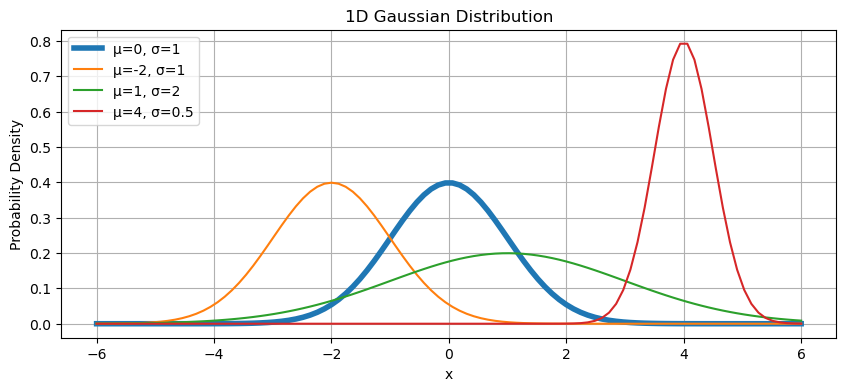

In [2]:
def plot_1d_gaussian(mu, sigma, axes, **kwargs):
    # Generate data
    x = np.linspace(-6, 6, 100)
    y = norm.pdf(x, mu, sigma)
    axes.plot(x, y, label=f'μ={mu}, σ={sigma}', **kwargs)

# Plot
plt.figure(figsize=(10, 4))
ax = plt.gca()

plot_1d_gaussian(0, 1, ax, linewidth=4)
plot_1d_gaussian(-2, 1, ax)
plot_1d_gaussian(1, 2, ax)
plot_1d_gaussian(4, 1/2, ax)

plt.title('1D Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

So what are Gaussian distributions in 2D?

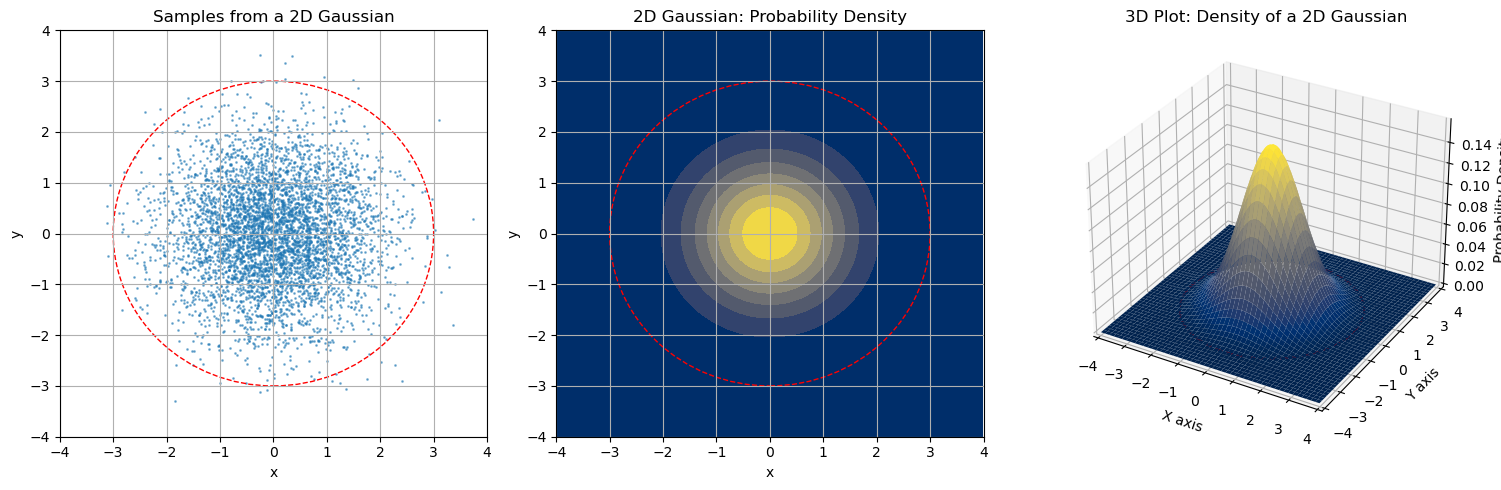

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Parameters
mu = [0, 0]  # Mean
cov = [[1, 0], [0, 1]]  # Covariance matrix

# Generate data
x, y = np.random.multivariate_normal(mu, cov, 5000).T

# Create grid for the probability density function
x_grid, y_grid = np.mgrid[-4:4:.02, -4:4:.02]
pos = np.empty(x_grid.shape + (2,))
pos[:, :, 0] = x_grid
pos[:, :, 1] = y_grid
rv = multivariate_normal(mu, cov)

# Plotting
fig = plt.figure(figsize=(15, 5))

# Scatter plot with ellipse
ax1 = fig.add_subplot(131)
ax1.scatter(x, y, s=1, alpha=0.5)
circle1 = plt.Circle(mu, 3, color='r', fill=False, linestyle='--')
ax1.add_patch(circle1)
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)
ax1.set_title('Samples from a 2D Gaussian')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True)

# Color-shaded plot
ax2 = fig.add_subplot(132)
ax2.contourf(x_grid, y_grid, rv.pdf(pos), cmap='cividis')
circle2 = plt.Circle(mu, 3, color='r', fill=False, linestyle='--')
ax2.add_patch(circle2)
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)
ax2.set_title('2D Gaussian: Probability Density')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.grid(True)

# 3D Surface plot
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(x_grid, y_grid, rv.pdf(pos), cmap='cividis', edgecolor='none')
ax3.set_xlim(-4, 4)
ax3.set_ylim(-4, 4)
ax3.set_title('3D Plot: Density of a 2D Gaussian')
ax3.set_xlabel('X axis')
ax3.set_ylabel('Y axis')
ax3.set_zlabel('Probability Density')

# Draw a dashed circle on the 3D plot
ax3.plot(np.cos(np.linspace(0, 2*np.pi, 100)) * 3, 
         np.sin(np.linspace(0, 2*np.pi, 100)) * 3, 
         0, 'r--')

# Show the plots
plt.tight_layout()
plt.show()

#### Formulas:

The 1D Gaussian distribution is defined by this equation:

$$ f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}} $$

The part out front is simply a normalizing constant. There's no $x$ in it. If we left this term off, this function would still look like a Gaussian. But the area under the curve would be $ \sqrt{2 \pi \sigma^2} $. Since the area under a probability distribution should be 1, we divide by that amount.

The rest of the formula has these elements:

- A difference between $x$ and the center, $mu$
  - squared
- Dividing by the standard deviation (width)

In higher dimensions, $x$ and $mu$ become vectors. $p(x)$ is still a real number, because it still assigns a *probability density* to each $x$. The spread parameter $\sigma$ is subtler. It becomes a *covariance matrix* $\Sigma$. 

$$ 
f(\mathbf{x}) = \frac{1}{\sqrt{(2 \pi)^k |\mathbf{\Sigma}|}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{x} - \mathbf{\mu})\right)
$$

**Don't skip!**: Run the plots above for a couple of $(\mu, \Sigma)$ combinations. Be sure to see what the covariance terms do.

**Q:**: Why can't the spread of a 2D Gaussian be described by a 2D number anymore?

#### Overly technical digression:

Back in 1D, a standard deviation had to be a positive number. In higher dimensions, the most natural generalization of the concept "positive number" to matrices is the *positive semi-definite* matrix. A PSD matrix is a square symmetric matrix with the property that for any vector $\mathbf{x}$, the product $\mathbf{x}^\top \mathbf{M} \mathbf{x} \geq 0$. This definition implies (among many other things) that the diagonal terms of PSD matrices are always positive, but the off-diagonal terms can be positive or negative.

#### Let's draw a 3D Gaussian

The easiest way to do this is as a point cloud. But remember that we're looking at a function from $\mathbf{R}^3$ to $\mathbf{R}^1$, which has the property that the area under the curve is 1.

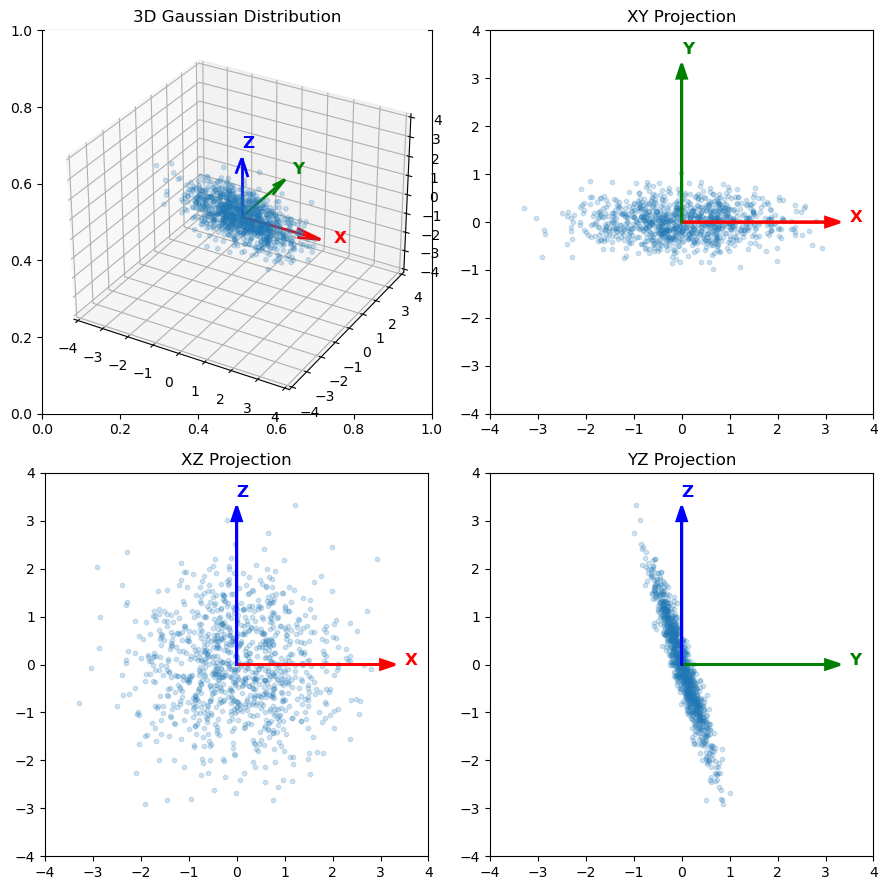

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Parameters
nsamples = 10000
mu = np.array([0, 0, 0])
cov = np.array(
    [[1, 0, 0], 
     [0, 0.1, -0.3], 
     [0, -0.3, 1]]
)

# Generate sample data
samples = np.random.multivariate_normal(mu, cov, num_points)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
ax3d = fig.add_subplot(221, projection='3d')
alpha = 0.2

# 3D Scatter Plot
ax3d.scatter(samples[:, 0], samples[:, 1], samples[:, 2], s=10, alpha=alpha)
ax3d.quiver(0, 0, 0, 3, 0, 0, color='r', linewidth=2)
ax3d.quiver(0, 0, 0, 0, 3, 0, color='g', linewidth=2)
ax3d.quiver(0, 0, 0, 0, 0, 3, color='b', linewidth=2)
ax3d.text(3.5, 0, 0, 'X', color='r', fontsize=12, weight='bold')
ax3d.text(0, 3.5, 0, 'Y', color='g', fontsize=12, weight='bold')
ax3d.text(0, 0, 3.5, 'Z', color='b', fontsize=12, weight='bold')
ax3d.set_title('3D Gaussian Distribution')
ax3d.set_xlim(-4, 4)
ax3d.set_ylim(-4, 4)
ax3d.set_zlim(-4, 4)

# 2D XY Projection
axs[0, 1].scatter(samples[:, 0], samples[:, 1], s=10, alpha=alpha)
axs[0, 1].arrow(0, 0, 3, 0, color='r', head_width=0.2, linewidth=2)
axs[0, 1].arrow(0, 0, 0, 3, color='g', head_width=0.2, linewidth=2)
axs[0, 1].text(3.5, 0, 'X', color='r', fontsize=12, weight='bold')
axs[0, 1].text(0, 3.5, 'Y', color='g', fontsize=12, weight='bold')
axs[0, 1].set_title('XY Projection')
axs[0, 1].set_xlim(-4, 4)
axs[0, 1].set_ylim(-4, 4)
axs[0, 1].set_aspect('equal')

# 2D XZ Projection
axs[1, 0].scatter(samples[:, 0], samples[:, 2], s=10, alpha=alpha)
axs[1, 0].arrow(0, 0, 3, 0, color='r', head_width=0.2, linewidth=2)
axs[1, 0].arrow(0, 0, 0, 3, color='b', head_width=0.2, linewidth=2)
axs[1, 0].text(3.5, 0, 'X', color='r', fontsize=12, weight='bold')
axs[1, 0].text(0, 3.5, 'Z', color='b', fontsize=12, weight='bold')
axs[1, 0].set_title('XZ Projection')
axs[1, 0].set_xlim(-4, 4)
axs[1, 0].set_ylim(-4, 4)
axs[1, 0].set_aspect('equal')

# 2D YZ Projection
axs[1, 1].scatter(samples[:, 1], samples[:, 2], s=10, alpha=alpha)
axs[1, 1].arrow(0, 0, 3, 0, color='g', head_width=0.2, linewidth=2)
axs[1, 1].arrow(0, 0, 0, 3, color='b', head_width=0.2, linewidth=2)
axs[1, 1].text(3.5, 0, 'Y', color='g', fontsize=12, weight='bold')
axs[1, 1].text(0, 3.5, 'Z', color='b', fontsize=12, weight='bold')
axs[1, 1].set_title('YZ Projection')
axs[1, 1].set_xlim(-4, 4)
axs[1, 1].set_ylim(-4, 4)
axs[1, 1].set_aspect('equal')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Novel View Synthesis

Imagine this scenario:

- You're given a bunch of images of a scene
- You run Structure from Motion, and it works
- You'd like to know how the scene looks from a new point of view

How could you do this?

In [ ]:
# brainstorm here









### Key Question: scene representation

- 3D points ([example](https://www.cs.cornell.edu/~snavely/bundler/images/Colosseum.jpg))
  - you get these from structure from motion automatically
  - but they don't look real
- meshes
  - easy to render
  - hard to compute
- patches ([example](https://www.di.ens.fr/cmvs/hall-all.jpg))
  - computable with effort
  - still looks kinda bad
- neural radiance field ([example](https://www.matthewtancik.com/nerf))
  - looks great!
  - takes days to compute
- blobs (today's topic)
  - easy to compute
  - easy to render
  - actually looks good
  - not as useful as a mesh

## 3D Gaussian Splatting

We're done with the warmup. We're ready to learn about a cool paper that is making real headway on the novel view generation problem

Here's the key paper that introduced this idea: 

- [3D Gaussian Splatting for Real-Time Radiance Field Rendering](https://arxiv.org/abs/2308.04079)
- [[results page link](https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/)]

The next cell sets up a random scene (a bunch of random Gaussians in 3D) and renders a 2D view of the scene. For simplicity, we're just doing greyscale.

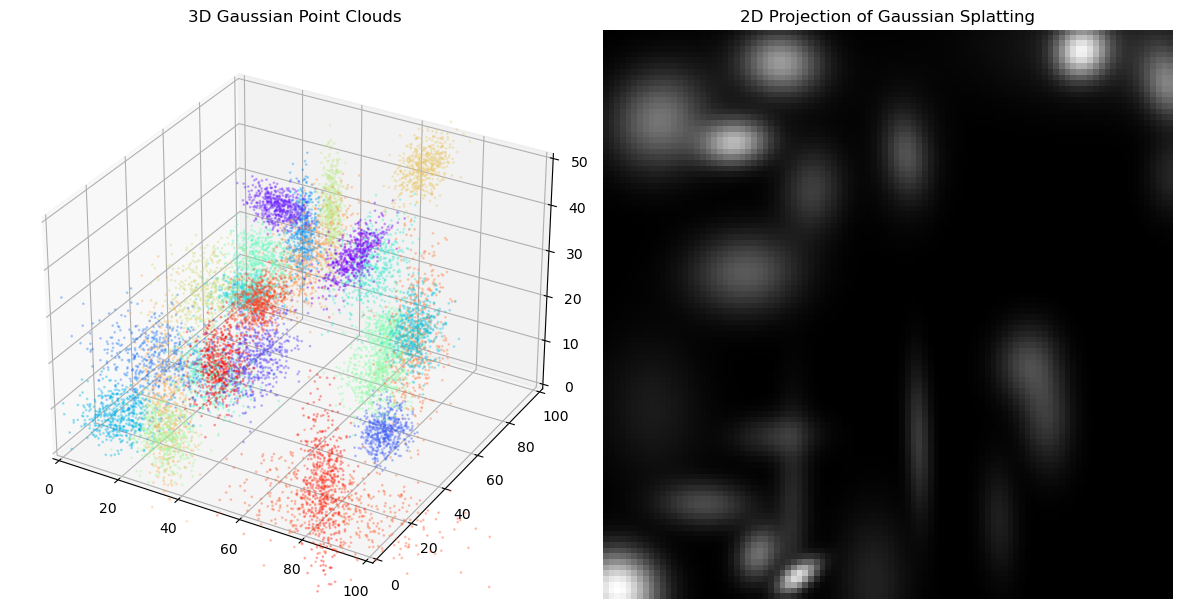

In [57]:
# Parameters
image_size = 100
num_splats = 25
depth_size = 50  # Depth range for 3D
samples_per_gaussian = 500
alpha_value = 0.3  # Transparency for plotting

# Create a blank 2D image
image = np.zeros((image_size, image_size))

# Random camera position (assume orthographic projection for simplicity)
camera_position = np.array([image_size / 2, image_size / 2, depth_size])

# Create 3D plot for visualization
fig = plt.figure(figsize=(12, 6))
ax3d = fig.add_subplot(121, projection='3d')

# Generate random 3D Gaussian splats
np.random.seed(0)  # For reproducibility
colors = plt.cm.rainbow(np.linspace(0, 1, num_splats))

for i in range(num_splats):
    # Random center in 3D
    mean = np.random.uniform(0, [image_size, image_size, depth_size])
    
    # Random anisotropic covariance matrix
    sigma_x, sigma_y, sigma_z = np.random.lognormal(3, 1, 3)
    cov_xy = np.random.uniform(-3, 3)
    cov = np.array([[sigma_x, cov_xy, 0], [cov_xy, sigma_y, 0], [0, 0, sigma_z]])
    
    # Sample points for each Gaussian (for 3D plot)
    points = np.random.multivariate_normal(mean, cov, samples_per_gaussian)
    
    # Plot the Gaussian point cloud in 3D
    ax3d.scatter(points[:, 0], points[:, 1], points[:, 2], color=colors[i], alpha=alpha_value, s=1)
    
    # Create a grid for projection onto the 2D plane
    x, y = np.meshgrid(np.arange(image_size), np.arange(image_size))
    pos_2d = np.dstack((x, y))
    
    # Adjust Gaussian for depth
    xy_projection = mean[:2] # xy projection is easy (lop off z coord)
    intensity = multivariate_normal.pdf(pos_2d, mean=xy_projection, cov=cov[:2, :2])
    
    # Update the image with Gaussian splat
    image += intensity / (mean[2] + 1)  # Depth-dependent blending

# Normalize the image
image /= np.max(image)

# 3D Plot settings
ax3d.set_title('3D Gaussian Point Clouds')
ax3d.set_xlim(0, image_size)
ax3d.set_ylim(0, image_size)
ax3d.set_zlim(0, depth_size)

# Plot the final 2D image
ax2d = fig.add_subplot(122)
ax2d.imshow(image, cmap='gray', extent=(0, image_size, 0, image_size))
ax2d.set_title('2D Projection of Gaussian Splatting')
ax2d.axis('off')

plt.tight_layout()
plt.show()

### 3DGS: the real version

To make this work for real, do this:

- Given: a bunch of images of a scene
- Initialization: run SfM
  - yields poses for all cameras
  - create a small Gaussian for each SfM 3D point
  - Give each Gaussian parameters: $\mu$, $\Sigma$, color
- Refinement (training) loop:
  - Render the scene from the viewpoint of a real camera
  - Diff the rendering with the real image
  - Loss function: $l_1$ or $l_2$ sum over pixel diffs
  - Refine the position / shape / color of all the Gaussians with a gradient descent step
  - Possibly thin out (or add to) the number of Gaussians if they are too dense or too sparse somewhere

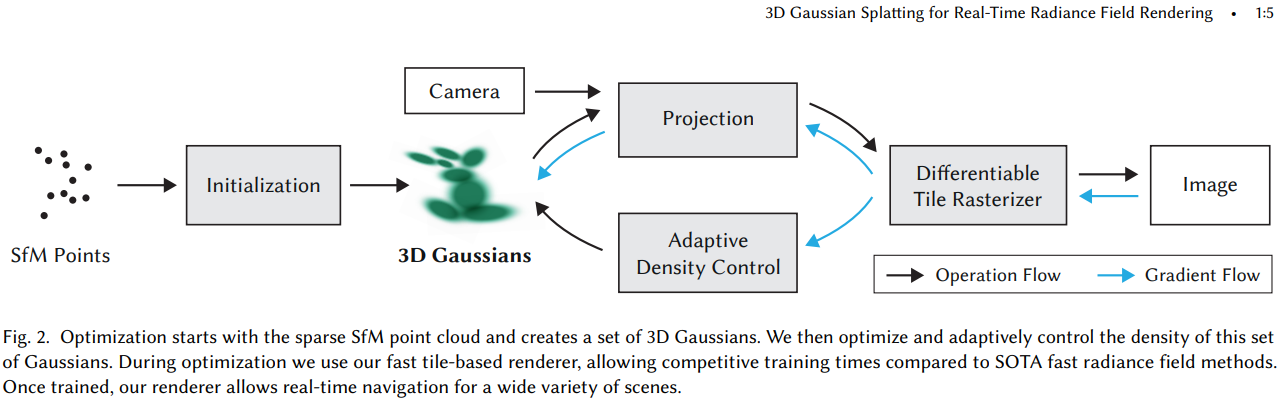

#### Color details:

- Easy mode: every Gaussian has an RGB color
- Hard mode: every Gaussian has a BRDF: *bidirectional radiance distribution function*. This is a graphics / rendering thing. Real materials look different from different angles. [[link: KB cloth rendering](https://www.cs.cornell.edu/projects/ctcloth/)]
  - Use spherical harmonics. (Think taylor series, but it 3D for things that are kind of spherish)

#### Blending details:

To do this right, 

- Each Gaussian has an alpha opacity
- The order of blending matters!
- Sort the splats by depth. Blend back to front.

#### If there's extra time:

Other fun details:

- Splatting is a hack for volume rendering
- The choice of loss function matters. The authors use a sum of $L_1$ and [D-SSIM](https://github.com/kornelski/dssim?tab=readme-ov-file). D-SSIM is a tweak on [SSIM](https://en.wikipedia.org/wiki/Structural_similarity_index_measure)
- Point cloud to 3D mesh approaches weren't that good for SfM points, but this [3DGS-to-mesh method](https://github.com/Anttwo/SuGaR) seems to really work!